# Attaque *Single Power Analysis* sur RSA
Cette attaque fait partie du challenge 2019 de la conférence francophone [SSTIC](https://www.sstic.org) sur la sécurité informatique. L'objectif sera de retrouver la clé privée utilisée lors d'une signature RSA à partir de l'analyse de la consommation de courant.

### Mise en oeuvre
On souhaite importer la mesure de consommation fournie dans le dossier `data`. L'extension de fichier .npz nous indique qu'il s'agit d'une archive NumPy, bibliothèque Python bien connue en data science. On utilise l'API NumPy pour charger le fichier et voir les données contenues :

In [1]:
import numpy as np
file = np.load('data/rsa.npz')
full_trace = file['arr_0']
print("shape", full_trace.shape)
print("data", full_trace)

shape (1842128,)
data [ 0.00387928  0.05724333 -0.01318807 ...  0.03482605  0.02234627
  0.09343685]


On retrouve un tableau NumPy à 1 dimension contenant 1 842 128 valeurs. On utilise Matplotlib pour afficher la courbe et voir grossièrement la forme pour identifier des zones d'intérêt.

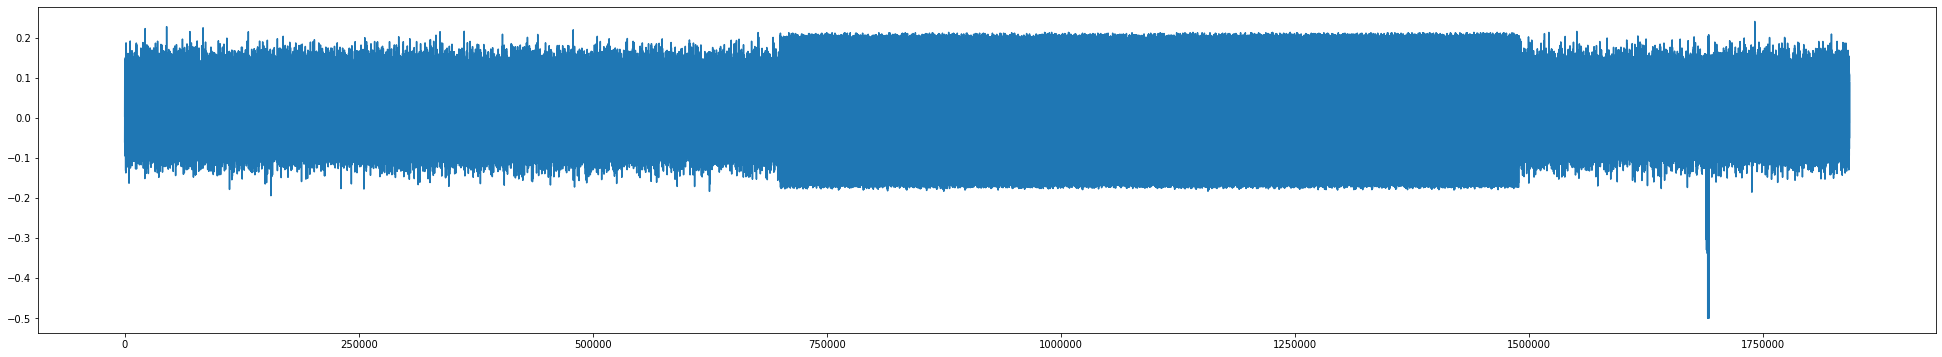

In [2]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (34, 6) # Configure la taille de la fenêtre Matplotlib, à adapter à votre écran si besoin
plt.plot(full_trace)
plt.show()

### Question 1
Identifier la zone d'intérêt qui pourrait correspondre à la succession d'opérations d'exponentiation modulaire. Afficher sur un graphique le début de la zone d'intérêt. 

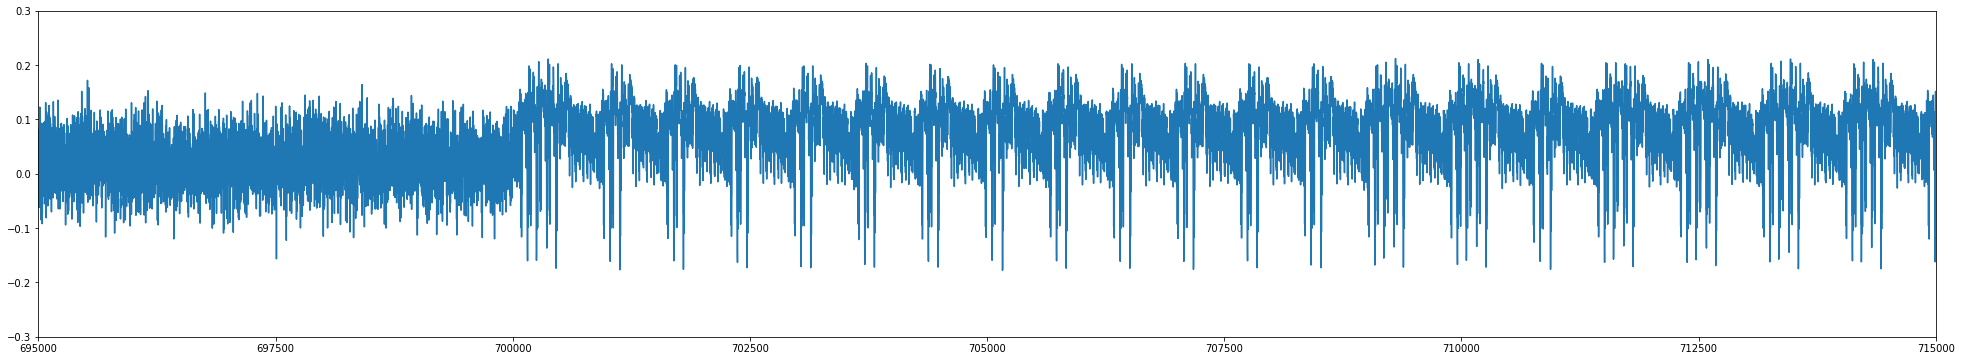

In [3]:
# Remplacer A1 et A2 pour mettre en évidence sur le graphique le début de la zone d'intérêt
plt.xlim(695000, 715000)
plt.ylim(-0.3, 0.3)
plt.plot(full_trace)
plt.show()

### Question 2
De la même façon, afficher sur un graphique la fin de la zone d'intérêt. Stocker enfin la trace sur laquelle l'attaque va être portée dans la variable `trace`.

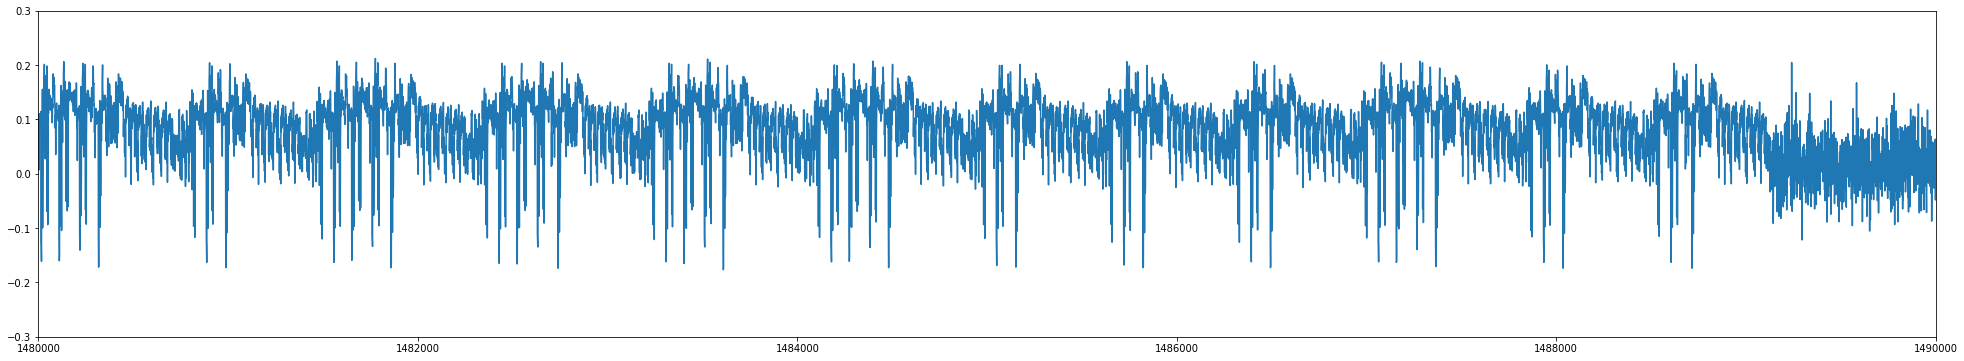

In [4]:
# Remplacer B1 et B2 pour mettre en évidence sur le graphique le début de la zone d'intérêt
plt.xlim(1480000, 1490000)
plt.ylim(-0.3, 0.3)
plt.plot(full_trace)
plt.show()

# Remplacer X et Y par les bornes de la zone d'intérêt
trace = full_trace[700000:1489000]

### Question 3
Inspecter la courbe en début de zone d'intérêt. Identifier visuellement le nombre de motifs différents présents afin de pouvoir faire l'hypothèse qu'il s'agit d'opérations de type *Square* et *Square* + *Multiply*.

On peut distingué 2 types de motifs différents. Un type que l'on peut définir comme *court* et un type que l'on peut définir comme *long*. On peut, par hypothèse définir que le motif *court* correpond à une opération **Square** et que le motif *long* corresponf à une opération **Sqaure + Multiply**.

### Question 4
Afficher les 8 opérations qui correspondent aux 8 premiers bits de l'exposant, et décoder manuellement ces 8 premiers bits.

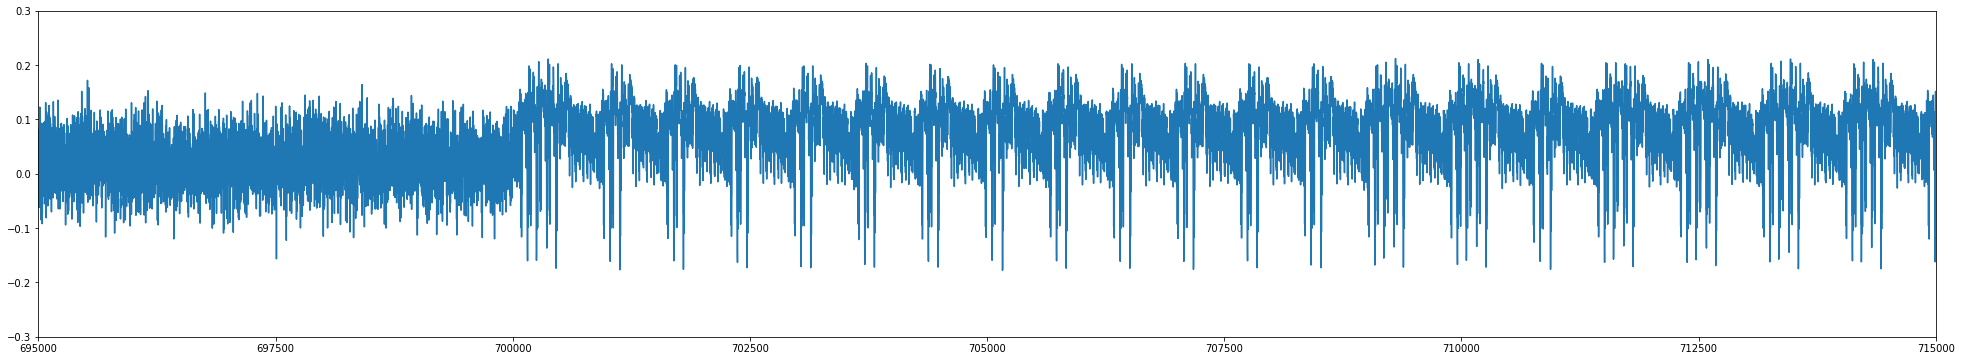

In [5]:
plt.xlim(695000, 715000)
plt.ylim(-0.3, 0.3)
plt.plot(full_trace)
plt.show()

On peut observer la suite d'opération suivante :
- Square + Multiply
- Square
- Square
- Square
- Square
- Square
- Square
- Square

Ce qui signifie que l'on a 0b10000000 soit 0x80

### Question 5
À l'aide de la fonction [`find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) de la bibliothèque `scipy.signal`, identifier les abscisses des différents pics négatifs présents tout au long de la courbe.

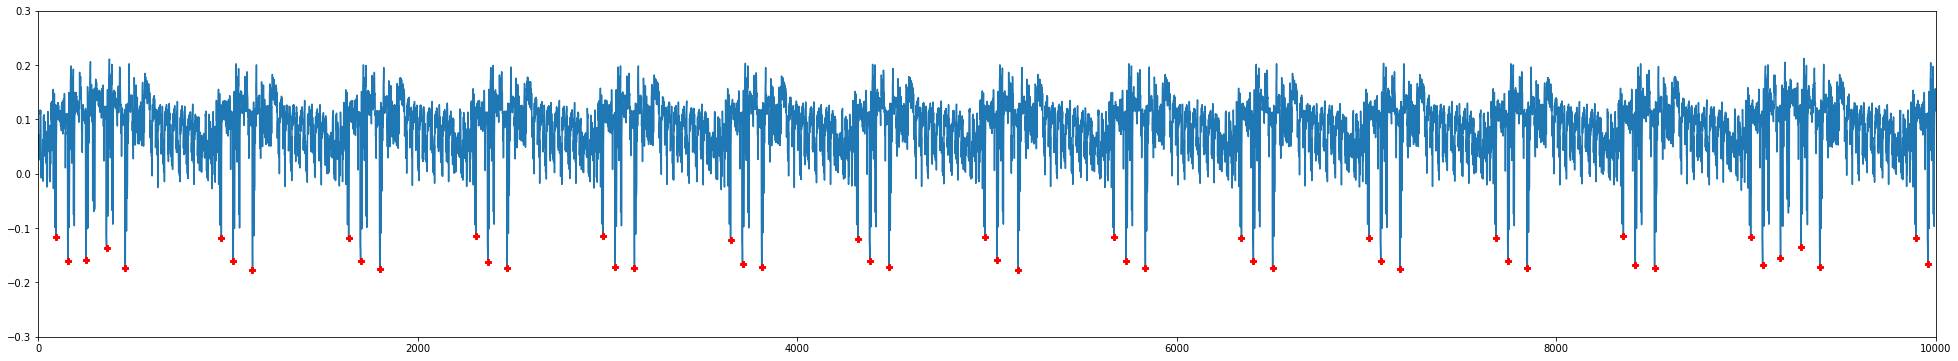

In [6]:
import scipy.signal

# Identifier des paramètres corrects pour détecter les pics présents sur la courbe
trace *=-1
peaks = scipy.signal.find_peaks(trace,height=0.1,distance = 50)[0]
trace *=-1

plt.xlim(0, 10000)
plt.ylim(-0.3, 0.3)
plt.plot(trace)
plt.plot(peaks, trace[peaks], marker='P', color='red', linestyle='none')
plt.show()

### Question 6
Valider également que les pics sont bien détectés sur la fin de la zone d'intérêt en affichant les pics détectés de la même manière mais sur la fin de la zone d'intérêt.

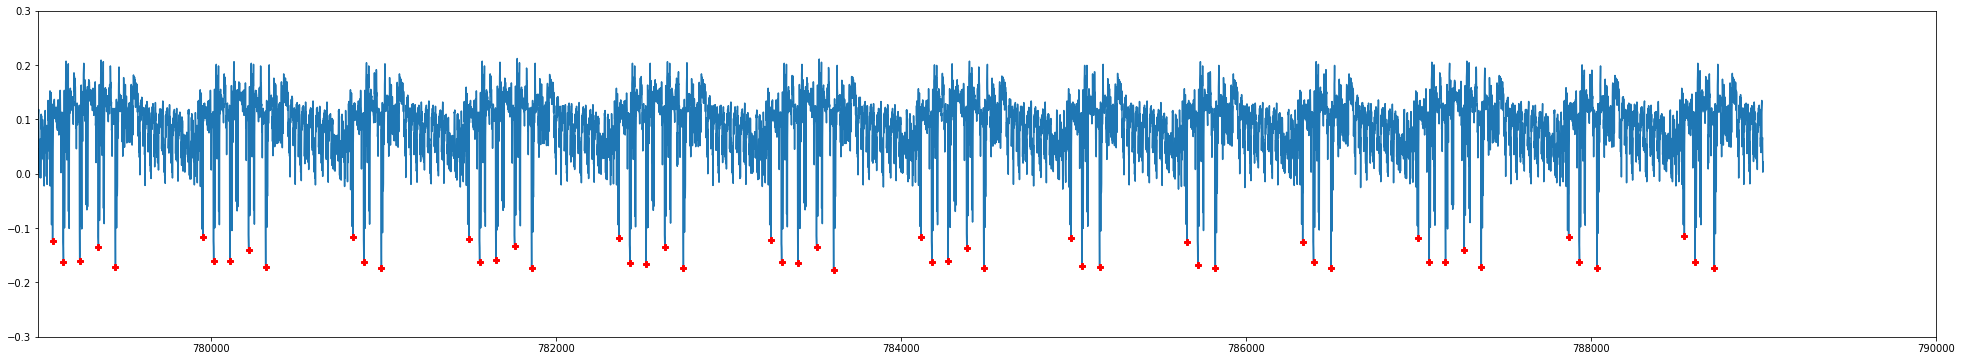

In [7]:
plt.xlim(779000, 790000)
plt.ylim(-0.3, 0.3)
plt.plot(trace)
plt.plot(peaks, trace[peaks], marker='P', color='red', linestyle='none')
plt.show()

### Question 7
Écrire un algorithme qui, à partir des abscisses des pics `peaks`, remplie la liste `bits` avec des entiers 0 ou 1 en fonction de la détection d'un motif à 3 pics ou d'un motif à 5 pics pour chaque opération.

In [8]:
bits = []
count = 0
# Remplir la liste bits

for i in range(1,len(peaks)):
    n = peaks[i-1]
    n1 = peaks[i]
    
    if n1-n < 150:
        count += 1
        if i == len(peaks)-1:
            if count == 2:
                bits.append(0)
            elif count == 4:
                bits.append(1)
            else:
                print("erreur")
                break        
    else:
        if count == 2:
            bits.append(0)
        elif count == 4:
            bits.append(1)
        else:
            print("erreur")
            break
        count = 0
        
assert len(bits) == 1024

### Question 8
À partir du tableau `bits`, reconstruire l'exposant `key`.

In [9]:
# Reconstruire key à partir de bits et vérifier avec :
#bits.reverse()
key = "".join(map(str,bits))
key= '0b'+key
key = int(key,2)
print(key)

from check import check
check(key)

89903710913347312807950016141473702637528070388720067064297955175120682114241728189964586239828798016825894536567406922006215012444870599437357707637087914996429784638052530041825408827666035825194672340176143332895658836886421032825311327583490909780231820496929125591586618689205991374773980232191261416388


True

On trouve le mot de passe qui est : 89903710913347312807950016141473702637528070388720067064297955175120682114241728189964586239828798016825894536567406922006215012444870599437357707637087914996429784638052530041825408827666035825194672340176143332895658836886421032825311327583490909780231820496929125591586618689205991374773980232191261416388